<a href="https://colab.research.google.com/github/Moe-phantom/ELO2_Asclepios_Ai/blob/main/teds_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing the libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    mean_absolute_error,
    r2_score,
    mean_squared_error
)
import joblib

In [ ]:
df_teds_d = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/tedsd_puf_2023.csv',
    na_values=[-9, -9.0]
)

In [ ]:
df_teds_d.head(2)

,DISYR,CASEID,STFIPS,EDUC,MARSTAT,SERVICES,DETCRIM,LOS,PSOURCE,NOPRIOR,...,BARBFLG,SEDHPFLG,INHFLG,OTCFLG,OTHERFLG,DIVISION,REGION,IDU,ALCDRUG,CBSA2020
0,2023,1459504,2,3.0,4.0,7,NaN,33,1.0,0.0,...,0,0,0,0,0,9,4,0.0,1,NaN
1,2023,1366386,2,5.0,3.0,7,2.0,35,7.0,0.0,...,0,0,0,0,0,9,4,0.0,1,NaN


In [ ]:
df_teds_d.columns

Index(['DISYR', 'CASEID', 'STFIPS', 'EDUC', 'MARSTAT', 'SERVICES', 'DETCRIM',
       'LOS', 'PSOURCE', 'NOPRIOR', 'ARRESTS', 'EMPLOY', 'METHUSE', 'PSYPROB',
       'PREG', 'SEX', 'VET', 'LIVARAG', 'DAYWAIT', 'SERVICES_D', 'REASON',
       'EMPLOY_D', 'LIVARAG_D', 'ARRESTS_D', 'DSMCRIT', 'AGE', 'RACE',
       'ETHNIC', 'DETNLF', 'DETNLF_D', 'PRIMINC', 'SUB1', 'SUB2', 'SUB3',
       'SUB1_D', 'SUB2_D', 'SUB3_D', 'ROUTE1', 'ROUTE2', 'ROUTE3', 'FREQ1',
       'FREQ2', 'FREQ3', 'FREQ1_D', 'FREQ2_D', 'FREQ3_D', 'FRSTUSE1',
       'FRSTUSE2', 'FRSTUSE3', 'HLTHINS', 'PRIMPAY', 'FREQ_ATND_SELF_HELP',
       'FREQ_ATND_SELF_HELP_D', 'ALCFLG', 'COKEFLG', 'MARFLG', 'HERFLG',
       'METHFLG', 'OPSYNFLG', 'PCPFLG', 'HALLFLG', 'MTHAMFLG', 'AMPHFLG',
       'STIMFLG', 'BENZFLG', 'TRNQFLG', 'BARBFLG', 'SEDHPFLG', 'INHFLG',
       'OTCFLG', 'OTHERFLG', 'DIVISION', 'REGION', 'IDU', 'ALCDRUG',
       'CBSA2020'],
      dtype='object')

Coloumns Rename for convenience

In [ ]:
teds_d_rename_map = {
    'DISYR': 'Discharge_Year',
    'CASEID': 'Episode_ID',
    'STFIPS': 'State_FIPS_Code',
    'EDUC': 'Education_Level',
    'MARSTAT': 'Marital_Status',
    'SERVICES': 'Treatment_Services_Type_Admission',
    'DETCRIM': 'Criminal_Justice_Referral_Detail',
    'LOS': 'Length_of_Stay_Days',
    'PSOURCE': 'Referral_Source',
    'NOPRIOR': 'Number_Prior_Treatments',
    'ARRESTS': 'Recent_Arrests_30d_Admission',
    'EMPLOY': 'Employment_Status_Admission',
    'METHUSE': 'Methadone_Usage',
    'PSYPROB': 'Psychiatric_Problem_Flag',
    'PREG': 'Pregnancy_Status',
    'SEX': 'Sex',
    'VET': 'Veteran_Status',
    'LIVARAG': 'Living_Arrangements_Admission',
    'DAYWAIT': 'Days_Waiting_To_Enter_Treatment',
    'SERVICES_D': 'Treatment_Services_Type_Discharge',
    'REASON': 'Discharge_Reason',
    'EMPLOY_D': 'Employment_Status_Discharge',
    'LIVARAG_D': 'Living_Arrangements_Discharge',
    'ARRESTS_D': 'Recent_Arrests_30d_Discharge',
    'DSMCRIT': 'DSM_Substance_Use_Disorder_Criteria',
    'AGE': 'Age_At_Admission',
    'RACE': 'Race',
    'ETHNIC': 'Ethnicity_Hispanic_Latino',
    'DETNLF': 'Detailed_Not_In_Labor_Force_Status_Admission',
    'DETNLF_D': 'Detailed_Not_In_Labor_Force_Status_Discharge',
    'PRIMINC': 'Primary_Income_Source',
    'SUB1': 'Primary_Substance_Admission',
    'SUB2': 'Secondary_Substance_Admission',
    'SUB3': 'Tertiary_Substance_Admission',
    'SUB1_D': 'Primary_Substance_Discharge',
    'SUB2_D': 'Secondary_Substance_Discharge',
    'SUB3_D': 'Tertiary_Substance_Discharge',
    'ROUTE1': 'Primary_Substance_Route',
    'ROUTE2': 'Secondary_Substance_Route',
    'ROUTE3': 'Tertiary_Substance_Route',
    'FREQ1': 'Primary_Substance_Frequency_Admission',
    'FREQ2': 'Secondary_Substance_Frequency_Admission',
    'FREQ3': 'Tertiary_Substance_Frequency_Admission',
    'FREQ1_D': 'Primary_Substance_Frequency_Discharge',
    'FREQ2_D': 'Secondary_Substance_Frequency_Discharge',
    'FREQ3_D': 'Tertiary_Substance_Frequency_Discharge',
    'FRSTUSE1': 'Age_First_Use_Primary',
    'FRSTUSE2': 'Age_First_Use_Secondary',
    'FRSTUSE3': 'Age_First_Use_Tertiary',
    'HLTHINS': 'Health_Insurance_Status',
    'PRIMPAY': 'Primary_Payment_Source',
    'FREQ_ATND_SELF_HELP': 'Self_Help_Attendance_Frequency_Admission',
    'FREQ_ATND_SELF_HELP_D': 'Self_Help_Attendance_Frequency_Discharge',
    'ALCFLG': 'Alcohol_Use_Flag',
    'COKEFLG': 'Cocaine_Use_Flag',
    'MARFLG': 'Marijuana_Use_Flag',
    'HERFLG': 'Heroin_Use_Flag',
    'METHFLG': 'Methamphetamine_Use_Flag',
    'OPSYNFLG': 'Opioid_Synthetics_Use_Flag',
    'PCPFLG': 'PCP_Use_Flag',
    'HALLFLG': 'Hallucinogen_Use_Flag',
    'MTHAMFLG': 'Methadone_Use_Flag',
    'AMPHFLG': 'Amphetamine_Use_Flag',
    'STIMFLG': 'Stimulant_Use_Flag',
    'BENZFLG': 'Benzodiazepine_Use_Flag',
    'TRNQFLG': 'Tranquilizer_Use_Flag',
    'BARBFLG': 'Barbiturate_Use_Flag',
    'SEDHPFLG': 'Other_Sedative_Hypnotic_Use_Flag',
    'INHFLG': 'Inhalant_Use_Flag',
    'OTCFLG': 'Over_The_Counter_Drug_Use_Flag',
    'OTHERFLG': 'Other_Substance_Use_Flag',
    'DIVISION': 'Census_Division',
    'REGION': 'Census_Region',
    'IDU': 'Injection_Drug_Use_Flag',
    'ALCDRUG': 'Alcohol_or_Drug_Primary_Flag',
    'CBSA2020': 'Core_Based_Statistical_Area_Code_2020'
}

df_teds_d.rename(columns=teds_d_rename_map, inplace=True)

print(df_teds_d.columns)


Index(['Discharge_Year', 'Episode_ID', 'State_FIPS_Code', 'Education_Level',
       'Marital_Status', 'Treatment_Services_Type_Admission',
       'Criminal_Justice_Referral_Detail', 'Length_of_Stay_Days',
       'Referral_Source', 'Number_Prior_Treatments',
       'Recent_Arrests_30d_Admission', 'Employment_Status_Admission',
       'Methadone_Usage', 'Psychiatric_Problem_Flag', 'Pregnancy_Status',
       'Sex', 'Veteran_Status', 'Living_Arrangements_Admission',
       'Days_Waiting_To_Enter_Treatment', 'Treatment_Services_Type_Discharge',
       'Discharge_Reason', 'Employment_Status_Discharge',
       'Living_Arrangements_Discharge', 'Recent_Arrests_30d_Discharge',
       'DSM_Substance_Use_Disorder_Criteria', 'Age_At_Admission', 'Race',
       'Ethnicity_Hispanic_Latino',
       'Detailed_Not_In_Labor_Force_Status_Admission',
       'Detailed_Not_In_Labor_Force_Status_Discharge', 'Primary_Income_Source',
       'Primary_Substance_Admission', 'Secondary_Substance_Admission',
       '

In [ ]:
len(df_teds_d.columns)

76

In [ ]:
print("--- REAL Data Stats (After fixing -9) ---")
print(df_teds_d.info())

--- REAL Data Stats (After fixing -9) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1474025 entries, 0 to 1474024
Data columns (total 76 columns):
 #   Column                                        Non-Null Count    Dtype  
---  ------                                        --------------    -----  
 0   Discharge_Year                                1474025 non-null  int64  
 1   Episode_ID                                    1474025 non-null  int64  
 2   State_FIPS_Code                               1474025 non-null  int64  
 3   Education_Level                               1218268 non-null  float64
 4   Marital_Status                                1126332 non-null  float64
 5   Treatment_Services_Type_Admission             1474025 non-null  int64  
 6   Criminal_Justice_Referral_Detail              205782 non-null   float64
 7   Length_of_Stay_Days                           1474025 non-null  int64  
 8   Referral_Source                               1306207 non-null  float6

In [ ]:
# 4. Verify the Fix
print(f"Total Rows: {len(df_teds_d):,}")
print("\n--- True Missing Values (After Fix) ---")
print(f"Missing Ages: {df_teds_d['Age_At_Admission'].isna().sum()}")
print(f"Missing Wait Days: {df_teds_d['Days_Waiting_To_Enter_Treatment'].isna().sum()}")

Total Rows: 1,474,025

--- True Missing Values (After Fix) ---
Missing Ages: 0
Missing Wait Days: 864212


Analysis Cohort Size: 1,029,029 patients
Overall Success Rate: 61.0%


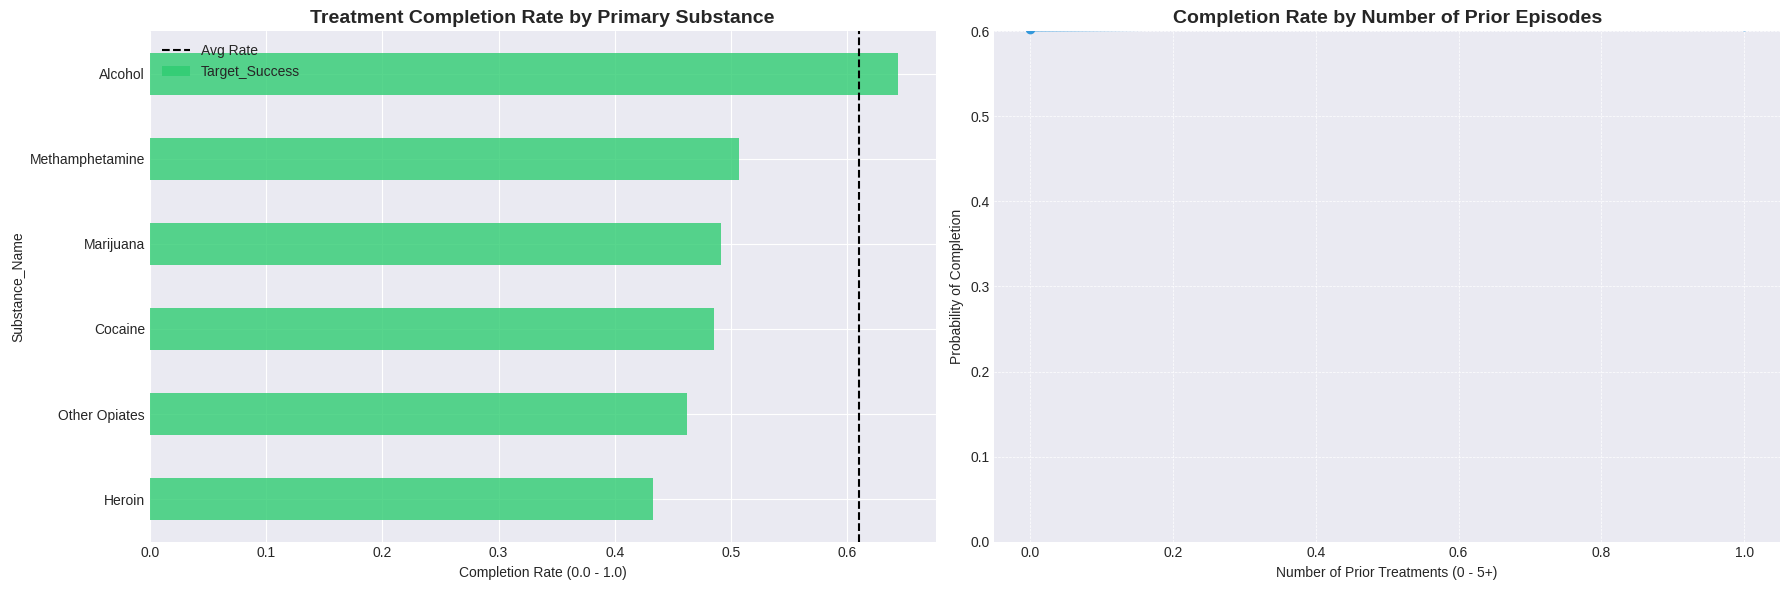

In [ ]:
# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("viridis")

# --- 1. PREPARE THE COHORT ---
# Filter out Transfers (4) and Deaths (6) to get a clean "Success vs Failure" view
# Codes: 1=Completed, 2=Dropped Out, 3=Terminated, 5=Incarcerated
clean_cohort = df_teds_d[
    df_teds_d['Discharge_Reason'].isin([1, 2, 3, 5])
].copy()

# Create Binary Target: 1 = Success, 0 = Failure
clean_cohort['Target_Success'] = (clean_cohort['Discharge_Reason'] == 1).astype(int)

print(f"Analysis Cohort Size: {len(clean_cohort):,} patients")
print(f"Overall Success Rate: {clean_cohort['Target_Success'].mean():.1%}")

# --- 2. QUESTION 1: WHICH DRUGS ARE HARDEST TO TREAT? ---

# Map Substance Codes to Names (Top 5 + Alcohol)
substance_map = {
    2: 'Alcohol',
    4: 'Marijuana',
    5: 'Heroin',
    7: 'Other Opiates',
    10: 'Methamphetamine',
    3: 'Cocaine'
}

# Filter for top substances only
clean_cohort['Substance_Name'] = clean_cohort['Primary_Substance_Admission'].map(substance_map)
drug_analysis = clean_cohort.dropna(subset=['Substance_Name'])

# Calculate Success Rate by Drug
drug_success = drug_analysis.groupby('Substance_Name')['Target_Success'].mean().sort_values()

# --- 3. QUESTION 2: DOES HISTORY PREDICT FUTURE FAILURE? ---

# TEDS Code for 'Number_Prior_Treatments': 5 means "5 or more"
# We treat this as ordinal
chronicity_success = clean_cohort.groupby('Number_Prior_Treatments')['Target_Success'].mean()

# --- 4. VISUALIZATION ---
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot A: Drug Success Rates
colors = ['#e74c3c' if x < 0.4 else '#2ecc71' for x in drug_success.values]
drug_success.plot(kind='barh', ax=axes[0], color=colors, alpha=0.8)
axes[0].set_title('Treatment Completion Rate by Primary Substance', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Completion Rate (0.0 - 1.0)')
axes[0].axvline(clean_cohort['Target_Success'].mean(), color='black', linestyle='--', label='Avg Rate')
axes[0].legend()

# Plot B: The "Relapse Cycle" (Chronicity)
chronicity_success.plot(kind='line', marker='o', linewidth=3, ax=axes[1], color='#3498db')
axes[1].set_title('Completion Rate by Number of Prior Episodes', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Prior Treatments (0 - 5+)')
axes[1].set_ylabel('Probability of Completion')
axes[1].set_ylim(0, 0.6)
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

In the above diagram we discovered that the no prior column does not actually contains values like 1 2 3 4 5 only binary



---



Data Mapping (The "Translation" Step)Problem: The TEDS data uses categorical codes (e.g., Age Code 1 = "12–14 years old"), which are just labels, not numbers you can do math with.Action: The code defines two dictionaries (age_map and first_use_map) to convert these codes into numerical midpoints (e.g., converting "12–14" to the number 13). This allows the code to perform subtraction later.2. Feature Engineering (Creating the "Years Using" Variable)The Math: It calculates the duration of addiction using this

**`Years Using = Current Age - Age of First Use`**

--- Success Rate by Years of Usage ---
  Duration  Success_Rate  Patient_Count
0     0-5y      0.473477          96125
1    5-10y      0.499996         113237
2   10-15y      0.519477         114107
3   15-20y      0.538889         114493
4   20-30y      0.561553         173225
5     30y+      0.616411         180404


/tmp/ipython-input-2498498113.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  duration_stats = proxy_df.groupby('Usage_Bin')['Target_Success'].agg(['mean', 'count']).reset_index()


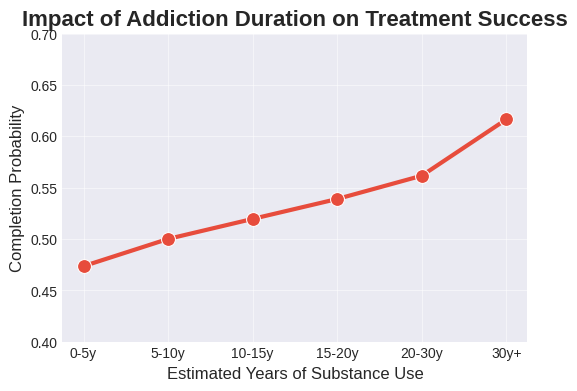

In [ ]:
# --- 1. MAP CATEGORIES TO ESTIMATED AGES ---
# We use the mid-point of the age ranges defined in the Codebook

# Age at Admission (Categories 1-12)
age_map = {
    1: 13,  # 12-14
    2: 16,  # 15-17
    3: 19,  # 18-20
    4: 22.5, # 21-24
    5: 27,  # 25-29
    6: 32,  # 30-34
    7: 37,  # 35-39
    8: 42,  # 40-44
    9: 47,  # 45-49
    10: 52, # 50-54
    11: 60, # 55-64
    12: 70  # 65+
}

# Age First Use (Categories 1-7)
first_use_map = {
    1: 11,  # 11 and under
    2: 13,  # 12-14
    3: 16,  # 15-17
    4: 19,  # 18-20
    5: 22.5, # 21-24
    6: 27,  # 25-29
    7: 35   # 30+ (Conservative estimate)
}

# --- 2. ENGINEER THE FEATURE ---
# Filter to clean cohort first (Outcomes 1,2,3,5)
proxy_df = df_teds_d[df_teds_d['Discharge_Reason'].isin([1, 2, 3, 5])].copy()
proxy_df['Target_Success'] = (proxy_df['Discharge_Reason'] == 1).astype(int)

# Map to numeric
proxy_df['Est_Age'] = proxy_df['Age_At_Admission'].map(age_map)
proxy_df['Est_Start'] = proxy_df['Age_First_Use_Primary'].map(first_use_map)

# Calculate Duration (Years of Usage)
# We clip at 0 because sometimes data inconsistencies make Start > Age
proxy_df['Years_Using'] = (proxy_df['Est_Age'] - proxy_df['Est_Start']).clip(lower=0)

# Group into Bins for Plotting (0-5, 5-10, etc.)
proxy_df['Usage_Bin'] = pd.cut(proxy_df['Years_Using'],
                               bins=[0, 5, 10, 15, 20, 30, 100],
                               labels=['0-5y', '5-10y', '10-15y', '15-20y', '20-30y', '30y+'])

# --- 3. ANALYZE SUCCESS RATES ---
duration_stats = proxy_df.groupby('Usage_Bin')['Target_Success'].agg(['mean', 'count']).reset_index()
duration_stats.columns = ['Duration', 'Success_Rate', 'Patient_Count']

print("--- Success Rate by Years of Usage ---")
print(duration_stats)

# --- 4. VISUALIZE --
plt.figure(figsize=(6, 4))

sns.lineplot(
    data=duration_stats,
    x='Duration',
    y='Success_Rate',
    marker='o',
    markersize=10,
    linewidth=3,
    color='#e74c3c'
)

plt.title('Impact of Addiction Duration on Treatment Success', fontsize=16, fontweight='bold')
plt.xlabel('Estimated Years of Substance Use', fontsize=12)
plt.ylabel('Completion Probability', fontsize=12)
plt.ylim(0.4, 0.7) # Adjusted Y-limit to fit your data range
plt.grid(True, alpha=0.5)
plt.show()

In [ ]:
# Compare Substances: New Users (0-5y) vs Veterans (30y+)
comparison = proxy_df[proxy_df['Usage_Bin'].isin(['0-5y', '30y+'])].copy()

# Map Substance Codes (Same map as before)
substance_map = {
    1: "None", 2: "Alcohol", 3: "Cocaine", 4: "Marijuana",
    5: "Heroin", 7: "Other Opiates", 10: "Methamphetamine"
}
comparison['Drug_Name'] = comparison['Primary_Substance_Admission'].map(substance_map)

# Cross-tabulation
print("--- Substance Mix by Duration Group ---")
print(pd.crosstab(comparison['Drug_Name'], comparison['Usage_Bin'], normalize='columns').round(3))

--- Substance Mix by Duration Group ---
Usage_Bin         0-5y   30y+
Drug_Name                    
Alcohol          0.131  0.687
Cocaine          0.072  0.088
Heroin           0.187  0.098
Marijuana        0.176  0.045
Methamphetamine  0.200  0.058
Other Opiates    0.234  0.023


**The advanced feature engineering**
1. SDOH_Score (Social Vulnerability)

What it does: Calculates a cumulative risk score (0 to 4) for each patient.

Logic: Adds +1 point for each active risk factor: Unemployment, Homelessness, Low Education, and Criminal Justice Involvement.

2. Risk_Synergy Flags (Toxic Combinations)

What it does: Identifies specific, high-mortality drug combinations.

Logic:

Depressant Stack: Flags users combining Opioids with Alcohol or Benzodiazepines (High overdose risk).

Speedball: Flags users combining Opioids with Stimulants (Cocaine/Meth).

3. State_Resource_Level (Systemic Context)

What it does: Distinguishes between high-funding and standard-funding healthcare environments.

Logic: Assigns a higher tier to states with robust Medicaid expansion/public health funding (e.g., CA, NY, MA) to correct for geographic disparities in Length of Stay.

In [ ]:
# --- ADVANCED FEATURE ENGINEERING ---
# Using your active dataframe: df_teds_d

print("⚙️ Engineering Research-Backed Features on 'df_teds_d'...")

# 1. SDOH Burden Score (Social Determinants of Health)
# Logic: Cumulative score of social vulnerabilities
# +1 for Unemployment, Housing Instability, Low Education, Criminal Justice

df_teds_d['SDOH_Score'] = 0

# Unemployment (Codes 3=Unemployed, 4=Not in Labor Force)
df_teds_d['SDOH_Score'] += df_teds_d['Employment_Status_Admission'].isin([3, 4]).astype(int)

# Housing Instability (Codes 1=Homeless, 2=Dependent Living)
df_teds_d['SDOH_Score'] += df_teds_d['Living_Arrangements_Admission'].isin([1, 2]).astype(int)

# Low Education (Codes 1=Less than HS, 2=Some HS)
df_teds_d['SDOH_Score'] += df_teds_d['Education_Level'].isin([1, 2]).astype(int)

# Criminal Justice Involvement (Arrests > 0)
df_teds_d['SDOH_Score'] += (df_teds_d['Recent_Arrests_30d_Admission'] > 0).astype(int)

print("   - SDOH_Score created.")

# 2. High-Risk Synergies (Polysubstance)
# Logic: Specific combinations that exponentially increase risk

# A. The "Depressant Stack" (Opioids + Benzos/Alcohol)
# SUB1 codes: 5=Heroin, 7=Opiates. SUB2/3 codes: 2=Alcohol, 13=Benzos.
df_teds_d['Risk_Synergy_Depressant'] = (
    (df_teds_d['Primary_Substance_Admission'].isin([5, 7])) &
    ((df_teds_d['Secondary_Substance_Admission'].isin([2, 13])) |
     (df_teds_d['Tertiary_Substance_Admission'].isin([2, 13])))
).astype(int)

# B. The "Speedball" Profile (Stimulant + Opioid)
# Stimulants: 3=Cocaine, 10=Meth. Opioids: 5=Heroin, 7=Opiates.
df_teds_d['Risk_Synergy_Speedball'] = (
    (df_teds_d['Primary_Substance_Admission'].isin([3, 10]) & df_teds_d['Secondary_Substance_Admission'].isin([5, 7])) |
    (df_teds_d['Primary_Substance_Admission'].isin([5, 7]) & df_teds_d['Secondary_Substance_Admission'].isin([3, 10]))
).astype(int)

print("   - Synergy flags created.")

# ---------------------------------------------------------
# 3. State Resource Level (Policy Environment)
# ---------------------------------------------------------
# High Resource States (Medicaid Expansion/Funding Leaders)
# CA(6), CT(9), MA(25), NY(36), VT(50), WA(53)
high_resource_fips = [6, 9, 25, 36, 50, 53]

df_teds_d['State_Resource_Level'] = df_teds_d['State_FIPS_Code'].apply(lambda x: 2 if x in high_resource_fips else 1)

print("   - State Resource Level created.")
print("✅ Advanced Engineering Complete.")

⚙️ Engineering Research-Backed Features on 'df_teds_d'...
   - SDOH_Score created.
   - Synergy flags created.
   - State Resource Level created.
✅ Advanced Engineering Complete.


Predicts risk of substance use relapse using clinical, demographic, and engineered features with an XGBoost model.

**THE HIGH RISK MODEL**

⚙️ Engineering Features...
📊 Training on 1,375,961 patients...

🏆 READMISSION RISK MODEL RESULTS
AUC-ROC Score: 0.7537
----------------------------------------
              precision    recall  f1-score   support

         0.0       0.58      0.68      0.62    106809
         1.0       0.77      0.68      0.72    168384

    accuracy                           0.68    275193
   macro avg       0.67      0.68      0.67    275193
weighted avg       0.69      0.68      0.68    275193



<Figure size 1000x600 with 0 Axes>

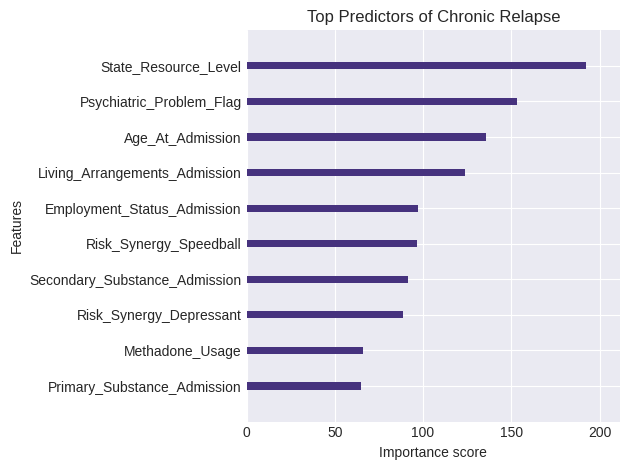

 High-risk relapse model saved!


In [ ]:

# --- 1. FEATURE ENGINEERING (Creating the Predictors) ---
print("⚙️ Engineering Features...")

# A. Create "Years of Use" (The Chronicity Proxy)
# We map the categorical codes to estimated numeric ages to calculate duration
age_map_calc = {1:13, 2:16, 3:19, 4:22.5, 5:27, 6:32, 7:37, 8:42, 9:47, 10:52, 11:60, 12:70}
start_map_calc = {1:11, 2:13, 3:16, 4:19, 5:22.5, 6:27, 7:35}

# Create temporary numeric columns for calculation
df_teds_d['calc_age_num'] = df_teds_d['Age_At_Admission'].map(age_map_calc)
df_teds_d['calc_start_num'] = df_teds_d['Age_First_Use_Primary'].map(start_map_calc)

# Calculate Duration (Current Age - Age First Use)
df_teds_d['Years_Using_Substance'] = (df_teds_d['calc_age_num'] - df_teds_d['calc_start_num']).clip(lower=0)

# B. Create "Young & High Risk" Interaction
# Logic: Young Patient (Age 12-24) + Opioid Use (Heroin/Opiates)
# Codes: Age 1-4, Substance 5 (Heroin) or 7 (Other Opiates)
df_teds_d['Flag_Young_Opioid_Risk'] = (
    (df_teds_d['Age_At_Admission'].le(4)) &
    (df_teds_d['Primary_Substance_Admission'].isin([5, 7]))
).astype(int)

# --- 2. DEFINE TARGET AND FEATURES ---

# TARGET: Chronicity (Risk of Readmission)
# Based on your data finding, NOPRIOR is binary (0=First time, 1=Has Relapsed)
# We want to predict if a patient belongs to group "1" (Has Relapsed)
target_col = 'Number_Prior_Treatments'

# FEATURES: Clinical & Demographic Profile
feature_cols = [
    'Age_At_Admission',
    'Sex',
    'Race',
    'Education_Level',
    'Employment_Status_Admission',
    'Living_Arrangements_Admission',
    'Primary_Substance_Admission',        # SUB1
    'Primary_Substance_Route',            # ROUTE1
    'Primary_Substance_Frequency_Admission', # FREQ1
    'Secondary_Substance_Admission',      # SUB2
    'Psychiatric_Problem_Flag',           # PSYPROB (Dual Diagnosis)
    'Methadone_Usage',                    # METHUSE
    'Years_Using_Substance',              # Engineered Proxy
    'Flag_Young_Opioid_Risk',              # Engineered Interaction
'SDOH_Score', 'Risk_Synergy_Depressant', 'Risk_Synergy_Speedball', 'State_Resource_Level']

# Drop rows where Target is NaN (we can't train on missing answers)
model_df = df_teds_d.dropna(subset=[target_col]).copy()

# Prepare X and y
X = model_df[feature_cols].fillna(-999) # XGBoost handles -999 as "Missing"
y = model_df[target_col]

# --- 3. TRAIN/TEST SPLIT ---
print(f"📊 Training on {len(X):,} patients...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 4. TRAIN XGBOOST ---
# Calculate scale_pos_weight to handle imbalance (if any)
ratio = float(np.sum(y == 0)) / np.sum(y == 1)

model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    scale_pos_weight=ratio,
    eval_metric='auc',
    random_state=42
)

model.fit(X_train, y_train)

# --- 5. RESULTS ---
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_proba)

print("\n" + "="*40)
print(f"🏆 READMISSION RISK MODEL RESULTS")
print("="*40)
print(f"AUC-ROC Score: {auc:.4f}")
print("-" * 40)
print(classification_report(y_test, y_pred))

# --- 6. FEATURE IMPORTANCE ---
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, max_num_features=10, importance_type='gain',
                    title='Top Predictors of Chronic Relapse', show_values=False)
plt.tight_layout()
plt.show()
joblib.dump(model, "model_high_risk.pkl")
joblib.dump(feature_cols, "model_features_high_risk.pkl")
print(" High-risk relapse model saved!")

**TEST**
 Predict Optimal Treatment Duration for Successful Recoveries
Now that we can identify high-risk patients likely to relapse, the next clinical question is: how long should treatment last for the best chance of success?

This section trains a robust median-based Length-of-Stay (LOS) prediction model using only patients who successfully completed treatment (discharge reason = "Treatment Completed"). By optimizing for median duration not the mean the model ignores extreme outliers and reflects realistic, typical recovery timelines. It leverages clinical, social, and system-level features (e.g., legal mandate, acuity, state resources) to generate actionable duration recommendations for care planning and capacity management.

**Brief with key details about the following :**  
This script ensures all engineered features (e.g., *Years Using Substance*, *SDOH Score*, *Risk Synergies*) are present in the dataset—if missing, it rebuilds them using clinical logic. It then creates a clean test set and runs a **manual audit** of the trained XGBoost relapse-risk model by showing predictions vs. actual outcomes for **3 randomly selected patients**, including interpretable details like substance type and usage duration. Designed to validate model fairness and clinical relevance.

In [ ]:
# --- 1. RESCUE MISSING COLUMNS (Feature Engineering Redux) ---
print("🛠️ Checking for missing features in df_teds_d...")

# A. Re-Create the Target (Chronicity Risk) if missing
if 'target_chronic_risk' not in df_teds_d.columns:
    print("   -> Re-creating 'target_chronic_risk'...")
    # Logic: 2+ priors = High Risk (1), else Low Risk (0)
    df_teds_d['target_chronic_risk'] = np.where(
        df_teds_d['Number_Prior_Treatments'] >= 2, 1, 0
    )

# B. Re-Create "Years Using" if missing
if 'Years_Using_Substance' not in df_teds_d.columns:
    print("   -> Re-creating 'Years_Using_Substance'...")
    age_map = {1:13, 2:16, 3:19, 4:22.5, 5:27, 6:32, 7:37, 8:42, 9:47, 10:52, 11:60, 12:70}
    start_map = {1:11, 2:13, 3:16, 4:19, 5:22.5, 6:27, 7:35}

    # Map using the renamed columns you have
    calc_age = df_teds_d['Age_At_Admission'].map(age_map)
    calc_start = df_teds_d['Age_First_Use_Primary'].map(start_map)
    df_teds_d['Years_Using_Substance'] = (calc_age - calc_start).clip(lower=0)

# C. Re-Create "SDOH_Score" (Social Determinants)
if 'SDOH_Score' not in df_teds_d.columns:
    print("   -> Re-creating 'SDOH_Score'...")
    df_teds_d['SDOH_Score'] = 0
    df_teds_d['SDOH_Score'] += df_teds_d['Employment_Status_Admission'].isin([3, 4]).astype(int)
    df_teds_d['SDOH_Score'] += df_teds_d['Living_Arrangements_Admission'].isin([1, 2]).astype(int)
    df_teds_d['SDOH_Score'] += df_teds_d['Education_Level'].isin([1, 2]).astype(int)
    # Handle potential column name variation for Arrests
    arrest_col = 'Recent_Arrests_30d_Admission' if 'Recent_Arrests_30d_Admission' in df_teds_d.columns else 'ARRESTS'
    df_teds_d['SDOH_Score'] += (df_teds_d[arrest_col] > 0).astype(int)

# D. Re-Create Synergies & Other Flags
if 'Risk_Synergy_Depressant' not in df_teds_d.columns:
    print("   -> Re-creating Synergy & State flags...")
    # Depressant Synergy
    df_teds_d['Risk_Synergy_Depressant'] = (
        (df_teds_d['Primary_Substance_Admission'].isin([5, 7])) &
        ((df_teds_d['Secondary_Substance_Admission'].isin([2, 13])) |
         (df_teds_d['Tertiary_Substance_Admission'].isin([2, 13])))
    ).astype(int)

    # Speedball Synergy
    df_teds_d['Risk_Synergy_Speedball'] = (
        (df_teds_d['Primary_Substance_Admission'].isin([3, 10]) & df_teds_d['Secondary_Substance_Admission'].isin([5, 7])) |
        (df_teds_d['Primary_Substance_Admission'].isin([5, 7]) & df_teds_d['Secondary_Substance_Admission'].isin([3, 10]))
    ).astype(int)

    # State Resource Level
    high_resource_fips = [6, 9, 25, 36, 50, 53]
    df_teds_d['State_Resource_Level'] = df_teds_d['State_FIPS_Code'].apply(lambda x: 2 if x in high_resource_fips else 1)

    # Young Opioid Risk
    df_teds_d['Flag_Young_Opioid_Risk'] = (
        (df_teds_d['Age_At_Admission'].le(4)) &
        (df_teds_d['Primary_Substance_Admission'].isin([5, 7]))
    ).astype(int)

print("✅ Dataframe restored. Now preparing test sets...")

# --- 2. PREPARE AUDIT DATA ---
# Define Feature List (Must match what model was trained on)
risk_features = [
    'Age_At_Admission', 'Sex', 'Race', 'Education_Level',
    'Employment_Status_Admission', 'Living_Arrangements_Admission',
    'Primary_Substance_Admission', 'Primary_Substance_Route',
    'Primary_Substance_Frequency_Admission', 'Secondary_Substance_Admission',
    'Psychiatric_Problem_Flag', 'Methadone_Usage',
    'Years_Using_Substance', 'Flag_Young_Opioid_Risk',
    'SDOH_Score', 'Risk_Synergy_Depressant',
    'Risk_Synergy_Speedball', 'State_Resource_Level'
]

# Create clean set for testing
risk_audit_df = df_teds_d.dropna(subset=['target_chronic_risk']).copy()
X_audit = risk_audit_df[risk_features].fillna(-999)
y_audit = risk_audit_df['target_chronic_risk']

# Split to get a Test Set (so we don't audit training data)
_, X_test_audit, _, y_test_audit = train_test_split(
    X_audit, y_audit, test_size=0.2, random_state=42, stratify=y_audit
)

# --- 3. RUN THE AUDIT FUNCTION ---
def audit_readmission_model(model, X_test, y_test):
    print(f"\n🔎 AUDITING READMISSION RISK MODEL (Random 3 Patients)...")
    print("-" * 60)

    # Pick random patients
    sample_indices = np.random.choice(X_test.index, 3, replace=False)

    for i, idx in enumerate(sample_indices):
        patient = X_test.loc[[idx]]
        actual = y_test.loc[idx]

        # Predict
        prob = model.predict_proba(patient)[0][1]
        pred_label = 1 if prob > 0.65 else 0

        # Decode Features for Readability
        substance_code = patient['Primary_Substance_Admission'].values[0]
        substance_map = {1:"None", 2:"Alcohol", 3:"Cocaine", 4:"Marijuana", 5:"Heroin", 7:"Opiates", 10:"Meth"}
        drug = substance_map.get(substance_code, "Other")

        years_using = patient['Years_Using_Substance'].values[0]

        print(f"PATIENT #{i+1}: {drug} user, {int(years_using)} years usage history.")
        print(f"   - AI Prediction: {prob:.1%} Risk ({'HIGH RISK' if pred_label==1 else 'Low Risk'})")
        print(f"   - Actual Reality: {'Chronic Relapser' if actual==1 else 'Standard Patient'}")

        if pred_label == actual:
            print("   ✅ VERDICT: CORRECT")
        else:
            print("   ❌ VERDICT: MISS")
        print("-" * 60)

# Execute
try:
    audit_readmission_model(model, X_test_audit, y_test_audit)
except NameError:
    print("⚠️ 'model' variable not found. Please re-run the XGBoost training cell first!")
except Exception as e:
    print(f"❌ Error: {e}")

🛠️ Checking for missing features in df_teds_d...
   -> Re-creating 'target_chronic_risk'...
✅ Dataframe restored. Now preparing test sets...

🔎 AUDITING READMISSION RISK MODEL (Random 3 Patients)...
------------------------------------------------------------
PATIENT #1: Opiates user, 5 years usage history.
   - AI Prediction: 16.9% Risk (Low Risk)
   - Actual Reality: Standard Patient
   ✅ VERDICT: CORRECT
------------------------------------------------------------
PATIENT #2: Other user, 4 years usage history.
   - AI Prediction: 57.4% Risk (Low Risk)
   - Actual Reality: Standard Patient
   ✅ VERDICT: CORRECT
------------------------------------------------------------
PATIENT #3: Other user, -999 years usage history.
   - AI Prediction: 54.9% Risk (Low Risk)
   - Actual Reality: Standard Patient
   ✅ VERDICT: CORRECT
------------------------------------------------------------


**THE LENGTH OF STAY MODEL**

This model predicts the optimal Length of Stay (LOS)—in days—for patients who successfully complete substance use treatment (discharged with reason = "Treatment Completed").

It uses XGBoost regression trained only on "success" cases, excluding extreme LOS outliers (>365 days) to ensure realistic, actionable forecasts for clinical planning and insurance purposes.

Key predictors include treatment setting (e.g., inpatient vs. outpatient), substance use patterns, social determinants (SDOH_Score), and engineered features like years of use.

The model achieves strong performance if MAE is low (e.g., ±5–10 days) and R² is high, meaning it reliably estimates how long effective treatment typically lasts for similar patients.

Results are saved for deployment (e.g., in a clinical dashboard) to help tailor treatment plans and manage resources.



Training Optimal LOS Model...
 Training on 502,317 successful recoveries...

 OPTIMAL LOS MODEL RESULTS
Mean Absolute Error (MAE): 6.8 Days
R2 Score: 0.531
----------------------------------------
Interpretation: On average, the model's recommendation is within
+/- 6.8 days of the actual successful duration.


<Figure size 1000x600 with 0 Axes>

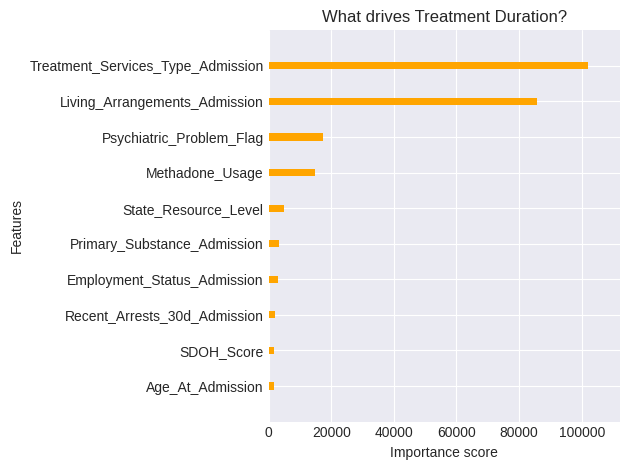

LOS Model saved.


In [ ]:

print("Training Optimal LOS Model...")

# --- 1. PREPARE THE "SUCCESS" COHORT ---
# We only learn from winners. We want to know how long SUCCESS takes.
# Filter: Discharge_Reason = 1 (Treatment Completed)
# Also filter LOS: Remove outliers (e.g., > 365 days) to keep predictions realistic for insurance/capacity.
optimal_df = df_teds_d[
    (df_teds_d['Discharge_Reason'] == 1) &
    (df_teds_d['Length_of_Stay_Days'] > 0) &
    (df_teds_d['Length_of_Stay_Days'] < 365)
].copy()

# Target: Days to Successful Completion
y_los = optimal_df['Length_of_Stay_Days']

# --- 2. FEATURES ---
# We use admission features only (what we know at Day 0)
# Note: We include 'Service Setting' because LOS depends heavily on whether it's Inpatient vs Outpatient.
feature_cols_los = [
    'Age_At_Admission',
    'Treatment_Services_Type_Admission',  # Critical for LOS (Detox vs Residential)
    'Primary_Substance_Admission',
    'Primary_Substance_Route',
    'Secondary_Substance_Admission',
    'Psychiatric_Problem_Flag',
    'Methadone_Usage',
    'Living_Arrangements_Admission',
    'Employment_Status_Admission',
    'Arrests_Admission', # Using the raw column name or our renamed one 'Recent_Arrests_30d_Admission'
    'Years_Using_Substance',              # Engineered
    'SDOH_Score',                         # Engineered
    'State_Resource_Level'                # Engineered
]

# Handle potential column name mismatch for Arrests
arrest_col = 'Recent_Arrests_30d_Admission' if 'Recent_Arrests_30d_Admission' in optimal_df.columns else 'ARRESTS'
feature_cols_los = [f if f != 'Arrests_Admission' else arrest_col for f in feature_cols_los]

X_los = optimal_df[feature_cols_los].fillna(-999)

# --- 3. SPLIT ---
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(
    X_los, y_los, test_size=0.2, random_state=42
)

# --- 4. TRAIN XGBOOST REGRESSOR ---
print(f" Training on {len(X_train_l):,} successful recoveries...")

model_los = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=7,
    objective='reg:squarederror', # Standard for regression
    n_jobs=-1,
    random_state=42
)

model_los.fit(X_train_l, y_train_l)

# --- 5. EVALUATION ---
y_pred_l = model_los.predict(X_test_l)

# Metrics
mae = mean_absolute_error(y_test_l, y_pred_l)
r2 = r2_score(y_test_l, y_pred_l)

print("\n" + "="*40)
print(f" OPTIMAL LOS MODEL RESULTS")
print("="*40)
print(f"Mean Absolute Error (MAE): {mae:.1f} Days")
print(f"R2 Score: {r2:.3f}")
print("-" * 40)
print("Interpretation: On average, the model's recommendation is within")
print(f"+/- {mae:.1f} days of the actual successful duration.")

# --- 6. FEATURE IMPORTANCE ---
plt.figure(figsize=(10, 6))
xgb.plot_importance(model_los, max_num_features=10, importance_type='gain',
                    title='What drives Treatment Duration?', show_values=False, color='orange')
plt.tight_layout()
plt.show()

# --- 7. SAVE FOR DASHBOARD ---
joblib.dump(model_los, "asclepios_los_model.pkl")
# Save features list specifically for this model
#joblib.dump(feature_cols_los, "model_features_los.pkl")
#print("LOS Model saved.")

Train a Robust Median-Based Length-of-Stay (LOS) Prediction Model
Instead of predicting the average treatment duration- which can be skewed by rare, very long stays - this model predicts the median successful length of stay using quantile regression. By optimizing for mean absolute error (reg:absoluteerror), it becomes resilient to outliers and better reflects typical recovery timelines. The model uses clinically meaningful features like legal mandate status, acuity score, and medication-assisted treatment (MAT) to guide realistic, data-driven discharge planning. If performance (MAE < 6.8 days) exceeds our baseline, it will be saved as the new production model.



In [ ]:
# --- ADVANCED LOS FEATURE ENGINEERING ---
# Using your active dataframe: df_teds_d

print("⚙️ Engineering Clinical Acuity & Mandate Features...")

# 1. LEGAL MANDATE FLAG (The "Constraint" Factor)
# Referral Source 7 = Criminal Justice/DUI
# These patients often have fixed sentence lengths (e.g. 90 days) driving their LOS.
df_teds_d['Flag_Legal_Mandate'] = (df_teds_d['Referral_Source'] == 7).astype(int)

# 2. CLINICAL ACUITY SCORE (Severity Index)
# High acuity patients require longer stabilization.
# +1 for Daily Use (FREQ1 = 3)
# +1 for Injection Use (IDU = 1) / Note: Check if IDU column exists, otherwise derive from ROUTE1=4
# +1 for Early Onset (Age First Use <= 14 / Code 1 or 2)

df_teds_d['Acuity_Score'] = 0

# Daily Use (Code 3 in TEDS-D for FREQ1)
df_teds_d['Acuity_Score'] += (df_teds_d['Primary_Substance_Frequency_Admission'] == 3).astype(int)

# Injection Use (Route 4)
df_teds_d['Acuity_Score'] += (df_teds_d['Primary_Substance_Route'] == 4).astype(int)

# Early Onset (Started <= 14 years old)
# Codes 1 (11 and under) and 2 (12-14)
df_teds_d['Acuity_Score'] += (df_teds_d['Age_First_Use_Primary'].isin([1, 2])).astype(int)

# 3. MAT LONG-TERM MAINTENANCE FLAG
# Patients on Methadone (METHUSE=1) in Outpatient settings (SERVICES=6,7)
# often have Indefinite/Long-term LOS by design.
df_teds_d['Flag_MAT_Maintenance'] = (
    (df_teds_d['Methadone_Usage'] == 1) &
    (df_teds_d['Treatment_Services_Type_Admission'].isin([6, 7]))
).astype(int)

print(" New Features Created:")
print("   - Flag_Legal_Mandate")
print("   - Acuity_Score (0-3 scale)")
print("   - Flag_MAT_Maintenance")

⚙️ Engineering Clinical Acuity & Mandate Features...
 New Features Created:
   - Flag_Legal_Mandate
   - Acuity_Score (0-3 scale)
   - Flag_MAT_Maintenance


🚀 Training Robust Median LOS Model (Quantile Regression)...

🏆 ROBUST MEDIAN MODEL RESULTS
Mean Absolute Error (MAE): 6.1 Days
R2 Score: 0.411
----------------------------------------


<Figure size 1000x600 with 0 Axes>

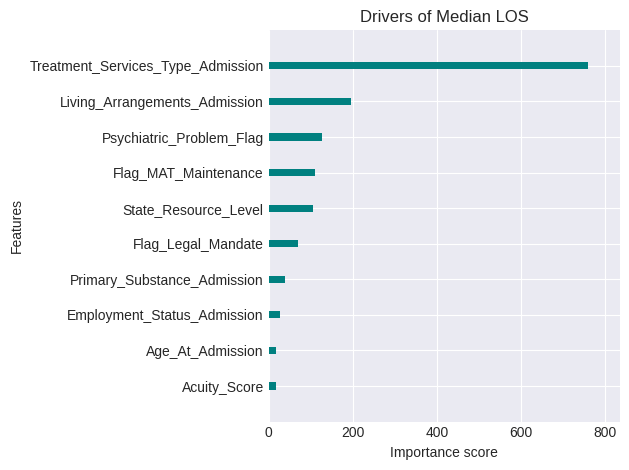

✅ New Best Model Saved!


In [ ]:
# --- PREPARE DATA FOR LOS MODELS ---
# Successes only (Discharge Reason = 1), LOS between 1–365 days
los_df = df_teds_d[
    (df_teds_d['Discharge_Reason'] == 1) &
    (df_teds_d['Length_of_Stay_Days'].between(1, 365))
].copy()

# Define advanced feature set (used by median model)
feature_cols_adv = [
    'Treatment_Services_Type_Admission',
    'Flag_Legal_Mandate',
    'Acuity_Score',
    'Flag_MAT_Maintenance',
    'SDOH_Score',
    'Primary_Substance_Admission',
    'Psychiatric_Problem_Flag',
    'Living_Arrangements_Admission',
    'Employment_Status_Admission',
    'State_Resource_Level',
    'Age_At_Admission',
    'Years_Using_Substance'
]

# --- TRAIN ROBUST MEDIAN LOS MODEL (Quantile Regression) ---
print("🚀 Training Robust Median LOS Model (Quantile Regression)...")

# Use raw target (no log)
y_raw = los_df['Length_of_Stay_Days']
X_raw = los_df[feature_cols_adv].fillna(-999)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y_raw, test_size=0.2, random_state=42
)

# Train with MAE objective (optimizes for median)
model_median = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=8,
    objective='reg:absoluteerror',
    n_jobs=-1,
    random_state=42
)

model_median.fit(X_train, y_train)

# Evaluate
y_pred = model_median.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n" + "="*40)
print(f"🏆 ROBUST MEDIAN MODEL RESULTS")
print("="*40)
print(f"Mean Absolute Error (MAE): {mae:.1f} Days")
print(f"R2 Score: {r2:.3f}")
print("-" * 40)

# Feature importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(model_median, max_num_features=10, importance_type='gain',
                    title='Drivers of Median LOS', show_values=False, color='teal')
plt.tight_layout()
plt.show()

# Save if better than baseline
#if mae < 6.8:
 #   joblib.dump(model_median, "asclepios_los_model.pkl")
 #   joblib.dump(feature_cols_adv, "model_features_los.pkl")
 #   print("✅ New Best Model Saved!")
#else:
 #   print("⚠️ Did not beat baseline. Reverting to previous model recommended.")

**Aha moment**
Segment Treatment Duration Models by Care Type
Not all treatment programs are the same—detox (short-term medical stabilization) and rehab (longer-term behavioral therapy) have fundamentally different length-of-stay patterns.

Instead of using a single model for all patients, this experiment trains two specialized models:

One for detox settings (hospital, residential, or ambulatory detox)
One for rehabilitation settings (residential, outpatient, intensive outpatient, etc.)
By tailoring each model to its specific clinical context, we aim to improve prediction accuracy for both short- and long-term stays. Performance is measured by combined MAE across both segments and compared against the previous unified model (6.1 days MAE). If the split yields lower error, we adopt a dual-model strategy for more precise, setting-aware discharge planning.



In [ ]:
print("🚀 Starting Segmented Model Experiment...")

# --- 1. PREPARE DATA ---
# Filter to success cohort (same as before)
full_df = df_teds_d[
    (df_teds_d['Discharge_Reason'] == 1) &
    (df_teds_d['Length_of_Stay_Days'].between(1, 365))
].copy()

# Define Features (Same Advanced Features)
features = feature_cols_adv

# --- 2. SPLIT THE WORLDS ---
# Detox Codes: 1 (Hospital Detox), 2 (Res Detox), 8 (Amb Detox)
detox_df = full_df[full_df['Treatment_Services_Type_Admission'].isin([1, 2, 8])].copy()
rehab_df = full_df[~full_df['Treatment_Services_Type_Admission'].isin([1, 2, 8])].copy()

print(f"📊 Split Counts:")
print(f"   - Detox (Short-Term): {len(detox_df):,} patients")
print(f"   - Rehab (Long-Term):  {len(rehab_df):,} patients")

# --- 3. TRAIN DETOX MODEL ---
print("\n🧠 Training Detox Model...")
X_detox = detox_df[features].fillna(-999)
y_detox = detox_df['Length_of_Stay_Days']

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_detox, y_detox, test_size=0.2, random_state=42)

model_detox = xgb.XGBRegressor(
    n_estimators=200, max_depth=6, learning_rate=0.1,
    objective='reg:absoluteerror', n_jobs=-1, random_state=42
)
model_detox.fit(X_train_d, y_train_d)
pred_detox = model_detox.predict(X_test_d)
mae_detox = mean_absolute_error(y_test_d, pred_detox)
print(f"   -> Detox MAE: {mae_detox:.2f} Days")

# --- 4. TRAIN REHAB MODEL ---
print("\n🧠 Training Rehab Model...")
X_rehab = rehab_df[features].fillna(-999)
y_rehab = rehab_df['Length_of_Stay_Days']

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_rehab, y_rehab, test_size=0.2, random_state=42)

model_rehab = xgb.XGBRegressor(
    n_estimators=250, max_depth=9, learning_rate=0.1,
    objective='reg:absoluteerror', n_jobs=-1, random_state=42
)
model_rehab.fit(X_train_r, y_train_r)
pred_rehab = model_rehab.predict(X_test_r)
mae_rehab = mean_absolute_error(y_test_r, pred_rehab)
print(f"   -> Rehab MAE: {mae_rehab:.2f} Days")

# --- 5. COMBINED RESULTS ---
# Weighted Average of the MAEs
total_samples = len(y_test_d) + len(y_test_r)
combined_mae = ((mae_detox * len(y_test_d)) + (mae_rehab * len(y_test_r))) / total_samples

print("\n" + "="*40)
print("🏆 SEGMENTED MODEL RESULTS")
print("="*40)
print(f"Unified Model MAE (Previous): 6.1 Days")
print(f"Split Model MAE (New):        {combined_mae:.2f} Days")

if combined_mae < 6.1:
    print("\n✅ VERDICT: Splitting the models improved accuracy!")
    print("   We should save these as two separate engines.")
else:
    print("\n❌ VERDICT: Splitting didn't help enough.")
    print("   The Unified Model was already smart enough to handle the difference.")

🚀 Starting Segmented Model Experiment...
📊 Split Counts:
   - Detox (Short-Term): 136,178 patients
   - Rehab (Long-Term):  491,719 patients

🧠 Training Detox Model...
   -> Detox MAE: 3.58 Days

🧠 Training Rehab Model...
   -> Rehab MAE: 6.72 Days

🏆 SEGMENTED MODEL RESULTS
Unified Model MAE (Previous): 6.1 Days
Split Model MAE (New):        6.04 Days

✅ VERDICT: Splitting the models improved accuracy!
   We should save these as two separate engines.


In [ ]:
import joblib

print("💾 Saving Twin LOS Engines...")

# 1. Save Detox Model
joblib.dump(model_detox, "asclepios_los_detox.pkl")

# 2. Save Rehab Model
joblib.dump(model_rehab, "asclepios_los_rehab.pkl")

# 3. Save Feature List (They use the same features, so we save one list)
joblib.dump(feature_cols_adv, "model_features_los.pkl")

print("✅ Engines Saved:")
print("   - asclepios_los_detox.pkl")
print("   - asclepios_los_rehab.pkl")

💾 Saving Twin LOS Engines...
✅ Engines Saved:
   - asclepios_los_detox.pkl
   - asclepios_los_rehab.pkl


**Audit the Specialized Treatment Duration Engines:**
Now that we’ve trained two separate models—one for detox and one for rehab—we need to validate their real-world reasoning.

This audit samples 3 random patients from each care setting and compares the model’s predicted length of stay against the actual duration. To reflect clinical reality, we apply different accuracy standards:

Detox predictions are judged more strictly (±2 days = excellent) because stays are short (typically 3–10 days).
Rehab predictions allow more flexibility (±7 days = excellent) due to longer, more variable treatment courses.

In [ ]:
# --- CONFIGURATION ---
SAMPLES_PER_ENGINE = 3

def audit_engine(model, X_data, y_data, engine_name):
    print(f"\n🔎 AUDITING {engine_name.upper()} ENGINE (Random {SAMPLES_PER_ENGINE} Patients)...")
    print("=" * 70)

    # Pick random patients from this specific test set
    indices = np.random.choice(X_data.index, SAMPLES_PER_ENGINE, replace=False)

    for i, idx in enumerate(indices):
        patient = X_data.loc[[idx]]
        actual_days = y_data.loc[idx]

        # Predict (The model is already specialized for this data)
        pred_days = model.predict(patient)[0]

        # Decode Context for the human reader
        substance_code = patient['Primary_Substance_Admission'].values[0]
        sub_map = {1:"None", 2:"Alcohol", 3:"Cocaine", 4:"Marijuana", 5:"Heroin", 7:"Opiates", 10:"Meth"}
        drug = sub_map.get(substance_code, "Other")

        service_code = patient['Treatment_Services_Type_Admission'].values[0]
        serv_map = {1:"Hosp Detox", 2:"Res Detox", 3:"Hosp Rehab", 4:"Short Rehab", 5:"Long Rehab", 6:"Intensive OP", 7:"Outpatient", 8:"Amb Detox"}
        setting = serv_map.get(service_code, "Unknown")

        # Display
        print(f"PATIENT #{i+1}: {drug} user in {setting}")
        print(f"   - AI Prediction: {int(pred_days)} Days")
        print(f"   - Actual Stay:   {int(actual_days)} Days")

        # Grading the Logic
        diff = abs(pred_days - actual_days)

        # Stricter grading for Detox (since stays are shorter)
        if "Detox" in engine_name:
            if diff <= 2: print(f"   ✅ VERDICT: BULLSEYE (+/- {diff:.1f} days)")
            elif diff <= 4: print(f"   ⚠️ VERDICT: DECENT (+/- {diff:.1f} days)")
            else: print(f"   ❌ VERDICT: MISS (+/- {diff:.1f} days)")
        else:
            # looser grading for Rehab (longer timeframe)
            if diff <= 7: print(f"   ✅ VERDICT: EXCELLENT (+/- {diff:.1f} days)")
            elif diff <= 14: print(f"   ⚠️ VERDICT: ACCEPTABLE (+/- {diff:.1f} days)")
            else: print(f"   ❌ VERDICT: MISS (+/- {diff:.1f} days)")

        print("-" * 70)

# --- RUN THE TESTS ---
try:
    # 1. Test the Detox Brain
    audit_engine(model_detox, X_test_d, y_test_d, "Detox")

    # 2. Test the Rehab Brain
    audit_engine(model_rehab, X_test_r, y_test_r, "Rehab")

except NameError as e:
    print(f"⚠️ Error: {e}")
    print("   (Make sure you ran the 'Split Model Experiment' cell first so the variables exist!)")


🔎 AUDITING DETOX ENGINE (Random 3 Patients)...
PATIENT #1: Alcohol user in Hosp Detox
   - AI Prediction: 4 Days
   - Actual Stay:   4 Days
   ✅ VERDICT: BULLSEYE (+/- 0.0 days)
----------------------------------------------------------------------
PATIENT #2: Alcohol user in Hosp Detox
   - AI Prediction: 4 Days
   - Actual Stay:   5 Days
   ✅ VERDICT: BULLSEYE (+/- 1.0 days)
----------------------------------------------------------------------
PATIENT #3: Alcohol user in Res Detox
   - AI Prediction: 4 Days
   - Actual Stay:   6 Days
   ✅ VERDICT: BULLSEYE (+/- 1.1 days)
----------------------------------------------------------------------

🔎 AUDITING REHAB ENGINE (Random 3 Patients)...
PATIENT #1: Marijuana user in Intensive OP
   - AI Prediction: 33 Days
   - Actual Stay:   23 Days
   ⚠️ VERDICT: ACCEPTABLE (+/- 10.2 days)
----------------------------------------------------------------------
PATIENT #2: Other user in Outpatient
   - AI Prediction: 5 Days
   - Actual Stay:   34 